In [1]:
# PyTorch Modules
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import models
from torchvision import transforms
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Other non-PyTorch Modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import time
from datetime import datetime
import pickle
import json
import random

In [2]:
torch.cuda.empty_cache()

In [3]:
now = datetime.now()
DATESTRING = now.strftime("%Y%m%d_%H%M")
print(DATESTRING)

20201020_1319


In [4]:
dataDF = pd.read_csv('data_fold.csv')
dataDF = dataDF.set_index('SOPInstanceUID')

In [5]:
dataDF.columns

Index(['StudyInstanceUID', 'SeriesInstanceUID', 'pe_present_on_image',
       'negative_exam_for_pe', 'qa_motion', 'qa_contrast', 'flow_artifact',
       'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1', 'leftsided_pe', 'chronic_pe',
       'true_filling_defect_not_pe', 'rightsided_pe', 'acute_and_chronic_pe',
       'central_pe', 'indeterminate', 'window_center', 'window_width',
       'intercept', 'slope', 'slice_thickness', 'kvp', 'ma', 'exposure',
       'img_pos', 'conv_kernel', 'patient_position', 'pixel_spacing',
       'bits_stored', 'high_bit', 'img_count', 'fold'],
      dtype='object')

In [6]:
dataDF = dataDF.reindex(columns=['StudyInstanceUID', 'SeriesInstanceUID', 'pe_present_on_image', 'negative_exam_for_pe',
                       'indeterminate', 'chronic_pe', 'acute_and_chronic_pe', 'central_pe', 'leftsided_pe',
                       'rightsided_pe', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1','fold','img_pos','patient_position',
                       'intercept', 'slope'])                  

In [7]:
dataDF.head()

,StudyInstanceUID,SeriesInstanceUID,pe_present_on_image,negative_exam_for_pe,indeterminate,chronic_pe,acute_and_chronic_pe,central_pe,leftsided_pe,rightsided_pe,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,fold,img_pos,patient_position,intercept,slope
SOPInstanceUID,,,,,,,,,,,,,,,,,
c0f3cb036d06,6897fa9de148,2bfbb7fd2e8b,0,0,0,0,0,0,1,1,0,1,3,-234.5,HFS,-1024,1
f57ffd3883b6,6897fa9de148,2bfbb7fd2e8b,0,0,0,0,0,0,1,1,0,1,3,-252.5,HFS,-1024,1
41220fda34a3,6897fa9de148,2bfbb7fd2e8b,0,0,0,0,0,0,1,1,0,1,3,-432.5,HFS,-1024,1
13b685b4b14f,6897fa9de148,2bfbb7fd2e8b,0,0,0,0,0,0,1,1,0,1,3,-434.5,HFS,-1024,1
be0b7524ffb4,6897fa9de148,2bfbb7fd2e8b,0,0,0,0,0,0,1,1,0,1,3,-436.5,HFS,-1024,1


In [8]:
trainDF = dataDF[dataDF['fold']!=0]
valDF = dataDF[dataDF['fold']==0]

In [9]:
class embeddingsDataset(Dataset):
    """create sample dataset to work with"""

    def __init__(self, dataDF = None, listOfStudies = None, embeddingDirPath = None):
        self.dataDF = dataDF
        self.listOfStudies = listOfStudies
        self.embeddingDirPath = embeddingDirPath

    def __len__(self):
        return len(self.listOfStudies)

    def __getitem__(self, idx):
        embedDict = pickle.load(open(self.embeddingDirPath+self.listOfStudies[idx]+'.p', 'rb'))
        embeddingVolume = np.array(embedDict['embeddings'])
        listOfImages = embedDict['ids']
        imageLevelLabels = [self.dataDF.loc[eachImageID, 'pe_present_on_image']for eachImageID in listOfImages]
        imageLevelLabels = np.array(imageLevelLabels).astype(np.float32)
        studyLevelLabels = self.dataDF.loc[listOfImages[0]][3:12].values
        studyLevelLabels = np.array(studyLevelLabels).astype(np.float32)
        return embeddingVolume, (imageLevelLabels, studyLevelLabels)

In [10]:
INPUT_SIZE = 64
HIDDEN_SIZE = 32
NUM_LAYERS = 1
NUM_CLASSES = 1

class BiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.GRU = nn.GRU(
            input_size, hidden_size, num_layers, batch_first=True, bidirectional=True
        )
        self.linear1 = nn.Linear(hidden_size*2, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_classes)
        self.linear3 = nn.Linear(hidden_size*2, hidden_size)
        self.linear4 = nn.Linear(hidden_size, 9)

    def forward(self, x):
        imageLevelOutputs = []
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).cuda()
        #c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).cuda()

        out, h_n = self.GRU(x, h0)
        
        for i, out_t in enumerate(out.chunk(out.size(1), dim=1)):
            out_t = out_t.squeeze(1)
            out_t = F.relu(self.linear1(out_t))
            out_t = self.linear2(out_t)
            imageLevelOutputs += [out_t]
        imageLevelOutputs = torch.stack(imageLevelOutputs, 1).squeeze(2)
        
        h_n = h_n.view(1,-1)
        studyLevelOutputs = F.relu(self.linear3(h_n))
        studyLevelOutputs = self.linear4(studyLevelOutputs)
        
        return (imageLevelOutputs, studyLevelOutputs)

In [11]:
seq = BiGRU(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).cuda()

# batch,seqNum,features
sampleInput = torch.rand((1,120,64)).cuda()
sampleImgOutput, sampleStdOutput = seq(sampleInput)
print(sampleImgOutput.size())
print(sampleStdOutput.size())

In [12]:
def customLoss(imageLevelOutputLogits, imageLevelLabels, studyLeveloutputLogits, studyLevelLabels, rho=0.5):
    imageLevelLoss = F.binary_cross_entropy_with_logits(imageLevelOutputLogits,imageLevelLabels,pos_weight = torch.tensor([3.0]).cuda())
    
    studyLevelLoss = 0
    weightList = [0.0736196319, 0.09202453988, 0.1042944785, 0.1042944785, 0.1877300613, 0.06257668712, 0.06257668712, 0.2346625767, 0.0782208589]
    for eachInd in range(9):
        studyLevelLoss += weightList[eachInd]*F.binary_cross_entropy_with_logits(studyLeveloutputLogits[:,eachInd],studyLevelLabels[:,eachInd])
    
    return rho*imageLevelLoss+(1-rho)*studyLevelLoss, imageLevelLoss, studyLevelLoss

def competitionMetric(imageLevelOutputLogits, imageLevelLabels, studyLeveloutputLogits, studyLevelLabels):
    imageLevelLoss = 0.07361963*(torch.sum(imageLevelLabels)/imageLevelLabels.size(1))*F.binary_cross_entropy_with_logits(imageLevelOutputLogits,imageLevelLabels,reduction='sum')
    
    studyLevelLoss = 0
    weightList = [0.0736196319, 0.09202453988, 0.1042944785, 0.1042944785, 0.1877300613, 0.06257668712, 0.06257668712, 0.2346625767, 0.0782208589]
    for eachInd in range(9):
        studyLevelLoss += weightList[eachInd]*F.binary_cross_entropy_with_logits(studyLeveloutputLogits[:,eachInd],studyLevelLabels[:,eachInd], reduction='sum')
    
    return imageLevelLoss+studyLevelLoss, imageLevelLabels.size(1)+9

In [13]:
optimizer = optim.Adam(seq.parameters(), lr=5e-5)

In [14]:
valEmbeddingDirPath = 'data/embeddings/CNNmodel_01_cv0_epoch1_20201014_0012/val/'
augEmbeddingDirPathBase = 'data/embeddings/CNNmodel_01_cv0_epoch1_20201014_0012/aug'

valEmbeddingsDataset = embeddingsDataset(dataDF=dataDF, listOfStudies=valDF['StudyInstanceUID'].unique(), embeddingDirPath=valEmbeddingDirPath)
valEmbeddingsDataloader = DataLoader(valEmbeddingsDataset, batch_size=1, shuffle=False, num_workers=1)

In [15]:
def train_loop(model, epoch):
    train_total = train_correct = train_cost_tot = train_cost1 = train_cost2 = 0
    seq.train()
    thisEmbeddingDirPath = augEmbeddingDirPathBase + str(epoch).zfill(2) + '/'
    thisEmbeddingsDataset = embeddingsDataset(dataDF=dataDF, listOfStudies=trainDF['StudyInstanceUID'].unique(), embeddingDirPath=thisEmbeddingDirPath)
    train_loader = DataLoader(thisEmbeddingsDataset, batch_size=1, shuffle=True, num_workers=1)
    for x, (y_img, y_std) in tqdm(train_loader):
        x = x.cuda()
        y_img = y_img.cuda()
        y_std = y_std.cuda()
        optimizer.zero_grad()
        (o_img, o_std) = seq(x)
        train_total += y_img.size(1)
        train_correct += ((torch.sigmoid(o_img[0,:])>0.5) == (y_img[0,:]>0.5)).sum().item()
        loss, loss1, loss2 = customLoss(o_img, y_img, o_std, y_std)
        loss.backward()
        optimizer.step()
        train_cost_tot += loss.item()
        train_cost1 += loss1.item()
        train_cost2 += loss2.item()
    return 100*train_cost_tot/train_total, 100*train_cost1/train_total, 100*train_cost2/train_total, train_correct/train_total 

def valid_loop(model, valid_loader):
    # Evaluate on validation  data 
    val_total = val_correct = val_cost_tot = val_cost1 = val_cost2 = val_metric_tot = rows_tot = 0
    model.eval()
    with torch.no_grad():
        for x_val, (y_val_img, y_val_std) in tqdm(valid_loader):
            x_val = x_val.cuda()
            y_val_img = y_val_img.cuda()
            y_val_std = y_val_std.cuda()
            (o_val_img, o_val_std) = seq(x_val)
            # Calculate loss and metric
            val_total += y_val_img.size(1)
            val_correct += ((torch.sigmoid(o_val_img[0,:])>0.5) == (y_val_img[0,:]>0.5)).sum().item()
            loss, loss1, loss2 = customLoss(o_val_img, y_val_img, o_val_std, y_val_std)
            metric, numRows = competitionMetric(o_val_img, y_val_img, o_val_std, y_val_std)
            val_cost_tot += loss.item()
            val_cost1 += loss1.item()
            val_cost2 += loss2.item()
            val_metric_tot += metric.item()
            rows_tot += numRows
    return 100*val_cost_tot/val_total, 100*val_cost1/val_total, 100*val_cost2/val_total, 100*val_metric_tot/rows_tot, val_correct/val_total

def main_loop(n_epochs):
    val_avgCostList = []
    val_Cost1List = []
    val_Cost2List = []
    for epoch in range(n_epochs):
        print('epoch ' + str(epoch) + ':')
        train_avgCost, train_Cost1, train_Cost2, train_acc = train_loop(seq, epoch)
        val_avgCost, val_Cost1, val_Cost2, val_compMetric, val_acc = valid_loop(seq, valEmbeddingsDataloader)
        val_avgCostList.append(val_avgCost)
        val_Cost1List.append(val_Cost1)
        val_Cost2List.append(val_Cost2)
        print('train_cost: %.4f, train_cost_img: %.4f, train_cost_std: %.4f,train_acc: %.4f'\
              % (train_avgCost, train_Cost1, train_Cost2, train_acc))
        print('val_cost: %.4f, val_cost_img: %.4f, val_cost_std: %.4f, val_compMetric: %.4f, val_acc: %.4f'\
              % (val_avgCost, val_Cost1, train_Cost2, val_compMetric, val_acc))
        modelPath = 'models/embedderModel/cv0/CNNmodel_01_cv0_epoch1_20201014_0012_sequence' + str(epoch) + '_' + DATESTRING +'.pth'
        print('saving: ',modelPath)
        torch.save(seq, modelPath)
    return val_avgCostList, val_Cost1List, val_Cost2List

# Note mistake in the model name!!!

In [16]:
# Note mistakes in the model name!!!
list1, list2, list3 = main_loop(10)

  0%|          | 0/5823 [00:00<?, ?it/s]

epoch 0:


  0%|          | 0/5823 [00:00<?, ?it/s]

train_cost: 0.1028, train_cost_img: 0.0667, train_cost_std: 0.1390,train_acc: 0.9679
val_cost: 0.0931, val_cost_img: 0.0726, val_cost_std: 0.1390, val_compMetric: 0.2135, val_acc: 0.9675
saving:  models/embedderModel/cv0/CNNmodel_01_cv0_epoch2_20201014_0901_sequence0_20201020_1319.pth
epoch 1:


  0%|          | 0/5823 [00:00<?, ?it/s]

train_cost: 0.0717, train_cost_img: 0.0502, train_cost_std: 0.0932,train_acc: 0.9732
val_cost: 0.0813, val_cost_img: 0.0696, val_cost_std: 0.0932, val_compMetric: 0.1917, val_acc: 0.9635
saving:  models/embedderModel/cv0/CNNmodel_01_cv0_epoch2_20201014_0901_sequence1_20201020_1319.pth
epoch 2:


  0%|          | 0/5823 [00:00<?, ?it/s]

train_cost: 0.0659, train_cost_img: 0.0491, train_cost_std: 0.0827,train_acc: 0.9735
val_cost: 0.0809, val_cost_img: 0.0720, val_cost_std: 0.0827, val_compMetric: 0.1905, val_acc: 0.9703
saving:  models/embedderModel/cv0/CNNmodel_01_cv0_epoch2_20201014_0901_sequence2_20201020_1319.pth
epoch 3:


  0%|          | 0/5823 [00:00<?, ?it/s]

train_cost: 0.0647, train_cost_img: 0.0484, train_cost_std: 0.0810,train_acc: 0.9741
val_cost: 0.0801, val_cost_img: 0.0708, val_cost_std: 0.0810, val_compMetric: 0.1888, val_acc: 0.9695
saving:  models/embedderModel/cv0/CNNmodel_01_cv0_epoch2_20201014_0901_sequence3_20201020_1319.pth
epoch 4:


  0%|          | 0/5823 [00:00<?, ?it/s]

train_cost: 0.0639, train_cost_img: 0.0475, train_cost_std: 0.0802,train_acc: 0.9751
val_cost: 0.0805, val_cost_img: 0.0719, val_cost_std: 0.0802, val_compMetric: 0.1901, val_acc: 0.9702
saving:  models/embedderModel/cv0/CNNmodel_01_cv0_epoch2_20201014_0901_sequence4_20201020_1319.pth
epoch 5:


  0%|          | 0/5823 [00:00<?, ?it/s]

train_cost: 0.0634, train_cost_img: 0.0477, train_cost_std: 0.0790,train_acc: 0.9749
val_cost: 0.0789, val_cost_img: 0.0682, val_cost_std: 0.0790, val_compMetric: 0.1878, val_acc: 0.9672
saving:  models/embedderModel/cv0/CNNmodel_01_cv0_epoch2_20201014_0901_sequence5_20201020_1319.pth
epoch 6:


  0%|          | 0/5823 [00:00<?, ?it/s]

train_cost: 0.0627, train_cost_img: 0.0472, train_cost_std: 0.0782,train_acc: 0.9750
val_cost: 0.0780, val_cost_img: 0.0677, val_cost_std: 0.0782, val_compMetric: 0.1852, val_acc: 0.9689
saving:  models/embedderModel/cv0/CNNmodel_01_cv0_epoch2_20201014_0901_sequence6_20201020_1319.pth
epoch 7:


  0%|          | 0/5823 [00:00<?, ?it/s]

train_cost: 0.0627, train_cost_img: 0.0473, train_cost_std: 0.0780,train_acc: 0.9751
val_cost: 0.0780, val_cost_img: 0.0686, val_cost_std: 0.0780, val_compMetric: 0.1847, val_acc: 0.9695
saving:  models/embedderModel/cv0/CNNmodel_01_cv0_epoch2_20201014_0901_sequence7_20201020_1319.pth
epoch 8:


  0%|          | 0/5823 [00:00<?, ?it/s]

train_cost: 0.0622, train_cost_img: 0.0472, train_cost_std: 0.0771,train_acc: 0.9749
val_cost: 0.0797, val_cost_img: 0.0715, val_cost_std: 0.0771, val_compMetric: 0.1886, val_acc: 0.9703
saving:  models/embedderModel/cv0/CNNmodel_01_cv0_epoch2_20201014_0901_sequence8_20201020_1319.pth
epoch 9:


100%|██████████| 1456/1456 [00:39<00:00, 37.11it/s]

train_cost: 0.0619, train_cost_img: 0.0465, train_cost_std: 0.0772,train_acc: 0.9757
val_cost: 0.0772, val_cost_img: 0.0682, val_cost_std: 0.0772, val_compMetric: 0.1843, val_acc: 0.9692
saving:  models/embedderModel/cv0/CNNmodel_01_cv0_epoch2_20201014_0901_sequence9_20201020_1319.pth


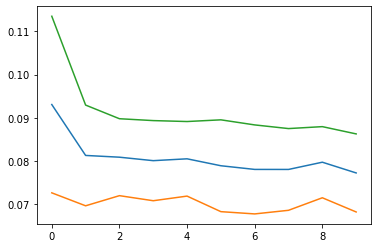

In [21]:
plt.plot(list1)
plt.plot(list2)
plt.plot(list3)

In [17]:
iterVal = iter(valEmbeddingsDataloader)

In [18]:
# Sanity Check
seq.eval()
with torch.no_grad():
    x,(y_img, _) = next(iterVal)
    x=x.cuda()
    o_img, _ = seq(x)
    pred = torch.sigmoid(o_img)
    for eachIndex in range(pred.size(1)):
        print((pred[0,eachIndex]).type(torch.float).item(), y_img[0, eachIndex].item())

0.0009033124661073089 0.0
0.0005709259421564639 0.0
0.00043395336251705885 0.0
0.00039422052213922143 0.0
0.0003740342508535832 0.0
0.00035327201476320624 0.0
0.00032831935095600784 0.0
0.0003413487283978611 0.0
0.0003516829165164381 0.0
0.0003477193822618574 0.0
0.0003532306000124663 0.0
0.00034345712629146874 0.0
0.0003345227742101997 0.0
0.00032930081943050027 0.0
0.0003195177996531129 0.0
0.0003292421461082995 0.0
0.0003074228297919035 0.0
0.0003179946797899902 0.0
0.00033059492125175893 0.0
0.00033379168598912656 0.0
0.00033630579127930105 0.0
0.00037190201692283154 0.0
0.00039421714609488845 0.0
0.0005195172852836549 0.0
0.000855035032145679 0.0
0.0007881468627601862 0.0
0.000917330093216151 0.0
0.0011043609119951725 0.0
0.0009291339083574712 0.0
0.0011502375127747655 0.0
0.0016806048806756735 0.0
0.001940552145242691 0.0
0.002063982654362917 0.0
0.0028843225445598364 0.0
0.004875782877206802 0.0
0.006577412132173777 0.0
0.009231621399521828 0.0
0.006140832789242268 0.0
0.0064558